In [1]:
#!c1.8
%cd dla/hw2_kws

[Errno 2] No such file or directory: 'dla/hw2_kws'
/home/jupyter/work/resources/dla/hw2_kws


# Import and misc

In [ ]:
# Instal latest torch and torchaudio

In [3]:
#!c1.8
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import random

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
#!c1.8
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [57]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 17:19:51--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.145.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.145.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  60.1MB/s    in 11s     

2022-11-06 17:20:02 (132 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
#!c1.8
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
#!c1.8
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
#!c1.8
dataset.csv.sample(5)

,path,keyword,label
21535,speech_commands/go/baeac2ba_nohash_0.wav,go,0
17825,speech_commands/bed/627c0bec_nohash_0.wav,bed,0
54628,speech_commands/four/4254621e_nohash_0.wav,four,0
31277,speech_commands/three/0447d7c1_nohash_0.wav,three,0
28417,speech_commands/marvin/eb609143_nohash_0.wav,marvin,0


### Augmentations

In [8]:
#!c1.8
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
#!c1.8
setup_seed(42)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
#!c1.8
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
#!c1.8
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
#!c1.8
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
#!c1.8
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
#!c1.8
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
#!c1.8
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
#!c1.8
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
#!c1.8
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
#!c1.8
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
#!c1.8
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
#!c1.8
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1) 
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [21]:
#!c1.8
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
#!c1.8
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [23]:
#!c1.8
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [24]:
#!c1.8
sum([p.numel() for p in model.parameters()])

25387

END OF EPOCH 19


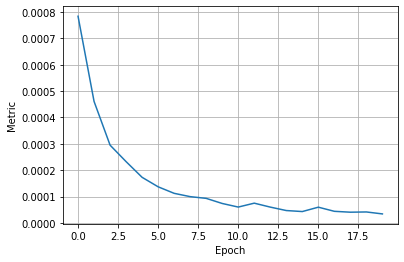

In [ ]:
#!c1.8
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
#!c1.8
#save_dict = model.state_dict()
#torch.save(save_dict, 'baseline.pt')

In [24]:
#!c1.8
ckpt = torch.load('baseline.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [78]:
#!c1.8
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 17.78it/s]


1.2919740513128531e-05

# Base metrics

In [25]:
#!c1.8
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [26]:
#!c1.8
from thop import profile  

batch, labels = next(train_loader.__iter__())
batch, labels = batch.to(config.device), labels.to(config.device)
batch = melspec_train(batch)
profile(model, (batch, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(55382016.0, 25387.0)

In [27]:
#!c1.8
MACS_CNT = 55382016.0

In [28]:
#!c1.8
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [29]:
#!c1.8
SIZE = get_size_in_megabytes(model)
SIZE

0.10348224639892578

# Distilation

В первую очередь я решил сделать обычную дистяляцию на логитах, просто взяв cross entropy на выходах моделей, но поскольку начал писать я это поздно вечером, то наломал кучу багов (которые позже найду), но это всё равно работало!!! Также я немного посмотрел на распределения вероятностей в батчах с разными температурами, и пришёл к выводу, что 7 это +- оптимальное, вероятности не слишком нормальные (мы не хотим, чтобы модель была слишком неуверена), но и крайних значений практически нет. Ещё я сразу уменьшил число каналов свёртки до 3, это не должно сильно повлиять на качество

In [31]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch)
            probs_teach = F.softmax(logits_teach, dim=-1) / temp
        logits_stud = student(batch)
        probs_stud = F.softmax(logits_stud, dim=-1)
        
        loss = F.cross_entropy(logits_stud, logits_teach)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [32]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 28, gru_num_layers = 2)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch.to(config_stud.device), ))
print('macs rate', MACS_CNT / macs )
_ = student(batch.to(config_stud.device))

size rate 1.914899687917967
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 2.1218981109127646


In [33]:
#!c1.8
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

13130

BEST SCORE: 5.341551839862054e-05
BEST EPOCH: 6
END OF EPOCH 7


 11%|█▏        | 46/405 [00:04<00:32, 11.04it/s]


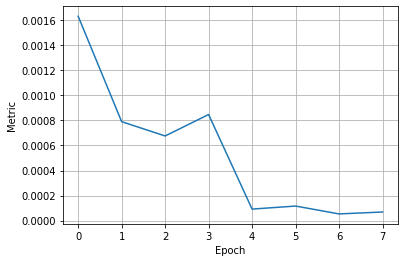

KeyboardInterrupt: ignored

In [34]:
#!c1.8
history = defaultdict(list)
best_score= 100
best_epoch = 0

for n in range(TaskConfig.num_epochs):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model1.pt')

    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

## Model 2

Простенькая модельку обучилась очень быстро, поэтому я решил уменьшить hidden size в 2 раза, это должно дать и скорости, и уменьшить размер.

In [35]:
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 14)
student = CRNN(config_stud).cuda()
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )

size rate 4.750608326328363
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 3.930023434519592


In [36]:
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

4758

In [38]:
history = defaultdict(list)
best_score = 100
best_epoch = 0 

for n in range(40):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model2.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)
    if best_score < 5e-5:
        break

Я перезапускал ячейку, т.к. хотел ещё дообучить, и не зря, так что это на самом деле 23 эпоха, а не 3

# Model 3

Я достаточно сильно уменьшил hidden size, но ничего не сделлал со свёрткой, а эта операция довольно тяжёлая, поэтому далее я решил ещё чуть чуть уменьшить hidden size и увеличить страйды

In [39]:
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 10, gru_num_layers = 2, stride=(3, 10))
student = CRNN(config_stud).cuda()
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 7.761329960245754
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 8.07675938025014


Здесь я решил посмотреть распределение максов по разным слоям, чтобы понять, что лучше оптимизировать

In [40]:
#!g1.1
batch_inp = batch.unsqueeze(dim=1)
macs_conv, _ = profile(student.conv, (batch_inp, ))
batch_conv = student.conv(batch_inp).transpose(-1, -2)
macs_gru, _ = profile(student.gru, (batch_conv, ))
batch_gru, _ = student.gru(batch_conv)
macs_attent, _ = profile(student.attention, (batch_gru, ))
batch_attent = student.attention(batch_gru)
macs_class, _ = profile(student.classifier, (batch_attent, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [41]:
#!g1.1
np.array([macs_conv, macs_gru, macs_attent, macs_class]) / macs

array([6.04816128e-01, 3.76330035e-01, 1.84804928e-02, 3.73343289e-04])

In [ ]:
#!g1.1
batch_inp = batch.unsqueeze(dim=1)
conv_output = student.conv(batch_inp).transpose(-1, -2)
gru_output, _ = student.gru(conv_output)
contex_vector = student.attention(gru_output)
output = student.classifier(contex_vector)

Как видим, больше всего приходится на свёртку и на гру

In [42]:
#!g1.1
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

2546

BEST SCORE: 3.7147983692482724e-05
BEST EPOCH: 18
END OF EPOCH 19


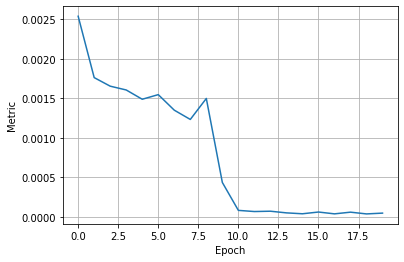

In [ ]:
#!g1.1
history = defaultdict(list)
best_score = 100
best_epoch = 0 
for n in range(40):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model3.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

In [43]:
history = defaultdict(list)
best_score = 100
best_epoch = 0 
for n in range(40):

    train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model3.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

# Model 4


Примерно на этом этапе меня достигло осознания того, что именно я написал в фукнции обучения, и шок от того, почему это вообще работало... Я пробовал несколько подходов к обучению: обучать с помощью MSE на логитах классификаторов, обучать с помощью KL дивергенции на вероятностях, добавлять к этому обычную ошибку модели на выборке (кросс энтропия с истинным ответом), но всё это показало худший результат даже с той багнутой функцией, которую я использовал до этого, причём тестировал я это не предыдущих моделях, и не мог выбить 5e-5... Поэтому было принято решения использовать обычную кросс энтропию (в некст секции). Я также ставил эксперименты с расписанием, но это ничего не дало, т.к. новая правильная функция потерь могла сходится ООООЧЕНЬ долго (200 и более эпох), а могла и быстро, поэтому подобрать нужно расписание становилось практически невозможно. Примерно тут же я обнаружил проблему с сидом и воспроизводимостью, и стал его фиксировать (ну чтоб точно всё было)

In [51]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp, shedulder=None):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) / temp
            probs_teach = F.softmax(logits_teach, dim=-1) 
        logits_stud = student(batch)
        probs_stud = F.softmax(logits_stud, dim=-1)
        
        loss = F.cross_entropy(logits_stud, probs_teach)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        if shedulder:
            shedulder.step()

        # logging
        argmax_probs = torch.argmax(probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [58]:
#!c1.8
def train_dist_epoch_kl(teacher, student, opt, loader, log_melspec, device, temp, shedulder=None):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) / temp
            probs_teach = F.softmax(logits_teach, dim=-1)
        logits_stud = student(batch) / temp
        log_probs_stud = F.log_softmax(logits_stud, dim=-1)
        
        loss1 = F.kl_div(log_probs_stud, probs_teach, log_target=False)
        loss2 = F.cross_entropy(logits_stud, labels)
        
        loss = loss1 + loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        if shedulder:
            shedulder.step()

        # logging
        argmax_probs = torch.argmax(log_probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [53]:
#!c1.8
def train_dist_epoch_mse(teacher, student, opt, loader, log_melspec, device, temp, shedulder=None):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) #/ temp
            probs_teach = F.softmax(logits_teach, dim=-1)
        logits_stud = student(batch) #/ temp
        log_probs_stud = F.log_softmax(logits_stud, dim=-1)
        
        #loss1 = F.kl_div(log_probs_stud, probs_teach, log_target=False)
        #loss2 = F.cross_entropy(logits_stud, labels)
        
        #loss = loss1 + loss2
        loss = F.mse_loss(logits_teach, logits_stud)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        if shedulder:
            shedulder.step()

        # logging
        argmax_probs = torch.argmax(log_probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


In [59]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 10, gru_num_layers = 2, stride=(3, 10))
setup_seed(1001)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 7.761329960245754
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 8.07675938025014


In [60]:
#!c1.8
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

2546

In [54]:
#!c1.8
shedulder = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=5e-3, epochs=30, steps_per_epoch=len(train_loader), pct_start=0.2)

BEST SCORE: 0.00018624417623301843
BEST EPOCH: 29
END OF EPOCH 29


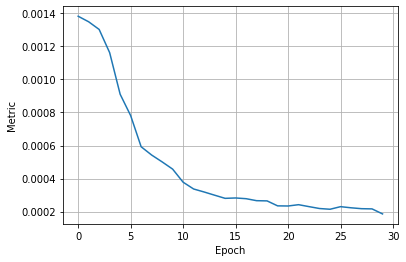

In [61]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(1001)

for n in range(30):

    train_dist_epoch_kl(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model4kl.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)
    if best_score <= 5.4e-5:
        print('NIIIICE')
        break

In [ ]:
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 10, gru_num_layers = 2, stride=(3, 10))
setup_seed(1001)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(1001)

for n in range(30):

    train_dist_epoch_mse(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'model4mse.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)
    if best_score <= 5.4e-5:
        print('NIIIICE')

# Model 5


Примерно тут (на самом деле раньше) мои усилия разделились на 2 нотбука 

В первом нотбуке (в этом) стратегия была в том, чтобы обучаться на cross entropy 10000 лет, но выбивать нормальное качество (и это работало). Во втором нотбуке (additional.ipynb) я хотел попробовать дистилировать по слоям. 

С первым всё +- понятно, я старался просто подбирать конфиг, и запускал на 10000 шагов, никаких фишек, ничего интересного, просто куча экспериментов с подбором гиперпараметров, поэтому поговорим про второй. 

Сразу определимся, модель - это большая модель, ученик - меньшая модель, её будем обучать по слоям. Идея была следующей, я хотел заменять большие слои маленькими по одному, соответственно для этого мне нужны были что то типо энкодеров-декодеров, чтобы я мог брать начало большой модели, пропускать через него картинку, пропускать выход через энкодер (чтобы он уменьшался), передавать блоку ученика, пропускать через декодер, а дальше пропускать через слои большой модели, таким образом обучить все слои ученика. Сначала я пытался обучить свёртку с большими страйдами, и меньшим ядром, (на mse loss между выходами), но ничего не работало. В качестве энкодеров (декодеров) я пробовал как Linear (до и после - решейпы), так и односвёрточные модели, но не завелось. Я также пробовал обучать гру, и это также не завелось. Я предположил, что проблема может быть в ненатуральности декодера, потому что мы 1) никак не используем уже обученные слои, 2) из за отличия трейна и инференса (когда мы будем использовать все слои ученика) может происходить накопление ошибки, и это плохо. Поэтому я решил изменить стратегию на следующую (пайплайн с кодом в нотбуке 2, Model 5): обучаем модель от выходов ко входу (от простого к сложному). В первую очередь как и в прошлый раз обучаем энкодер-декодер перед нужным слоем, которые будут отражат в (из) меншьую размерность. Далее используя энкодер, обучаем слой (в первую очередь классификатор). На следующем шаге опять же обучаем сначала энкодер-декодер перед слоем. После чего начинаем обучать слой следующим образом: пропускаем батч через ориг модель до этого слоя, далее (1) энкодим батч в меньшую размерность, пропускаем через обучаемый слой ученика, (2) исходный батч пропускам через тот же слой учителя, берём энкодер с ПРЕДЫДУЩЕГО шага, отражаем результат учителя в меньшую размерность (энкодером с прошлого шага), берём мсе от (1) и (2). Т.е. отличие от предыдущего подхода в том, что мы не используем декодер, и на практике это действительно помогло. Также была ещё идея на каждом шаге дообучать уже обученную часть ученика на обычном лоссе (cross entropy), т.к. предложенного пайплайна на маленькх моделях не хватало (сложно было обучать гру), но это я попробовать не успел.

Т.к. с обучением свёртки методом 2 были проблемы, сновная идея была в том, чтобы увеличить скорость изменением свёртки методом 1, и применить данную модель как учитель в методе 2, чтобы уменьшить hidden size.

Код описанного подхода (второго) можно найти в нотбуке additional.ipynb в секции Model 5

In [ ]:
#!c1.8
def train_dist_epoch(teacher, student, opt, loader, log_melspec, device, temp):
    student.train()
    teacher.eval()
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            logits_teach = teacher(batch) / temp
            probs_teach = F.softmax(logits_teach, dim=-1) 
        logits_stud = student(batch) / temp
        probs_stud = F.softmax(logits_stud, dim=-1)
        
        loss = F.cross_entropy(logits_stud, probs_teach)
        #loss = F.mse_loss(logits_teach, logits_stud)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs_stud, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
#!c1.8
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)
ckpt = torch.load('baseline.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [ ]:
#!c1.8
validation(model, val_loader,
                          melspec_val, config_stud.device)

102it [00:09, 10.66it/s]


1.2609428038910201e-05

In [ ]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 7, kernel_size=(5, 18), stride=(3, 10))
setup_seed(42)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

size rate 9.642673064960455
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 10.279930623203212


In [ ]:
#!c1.8
opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

1634

BEST SCORE: 9.206434030775537e-05
BEST EPOCH: 176
END OF EPOCH 178


 77%|███████▋  | 310/405 [00:39<00:09, 10.16it/s]

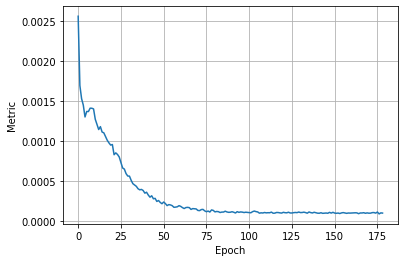

In [ ]:
#!c1.8
history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(400):

    loss = train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'MEGAsuper.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    #print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

BEST SCORE: 4.6552838680330565e-05
BEST EPOCH: 366
END OF EPOCH 382


 45%|████▌     | 184/405 [00:23<00:28,  7.69it/s]


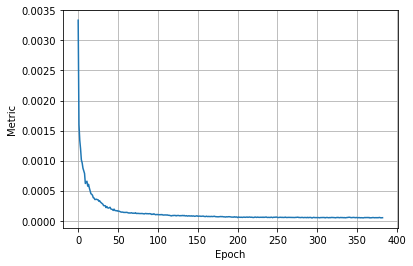

KeyboardInterrupt: 

In [ ]:
#!c1.8
config_stud = TaskConfig(cnn_out_channels=3, hidden_size = 10, kernel_size=(4, 18), stride=(2, 14))
setup_seed(42)
student = CRNN(config_stud).to(config_stud.device)
print('size rate', SIZE / get_size_in_megabytes(student))
macs, _ = profile(student, (batch, ))
print('macs rate', MACS_CNT / macs )
_ = student(batch)

opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
sum([p.numel() for p in student.parameters()])

history = defaultdict(list)
best_score = 100
best_epoch = 0 
setup_seed(42)

for n in range(400):

    loss = train_dist_epoch(model, student, opt, train_loader,
                melspec_train, config_stud.device, 7)

    au_fa_fr = validation(student, val_loader,
                          melspec_val, config_stud.device)
    history['val_metric'].append(au_fa_fr)
    if au_fa_fr < best_score:
        best_score = au_fa_fr
        best_epoch = n
        state = student.state_dict()
        torch.save(state, 'megasuper.pt')

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    #print(loss)
    print(f'BEST SCORE: {best_score}')
    print(f'BEST EPOCH: {best_epoch}')
    print('END OF EPOCH', n)

# Model 6


В этом разделе я применю квантизацию к своей лучшей моделе (а получилась она из метода 1, потому что я не успеваю доууменьшить лучшую модель из 1 методом 2, а она обогнала предыдующую лучшую со 2 метода :с). Выбрал динамическую квантизацию, т.к. с ней можно будет квантизировать гру.

In [30]:
#!c1.8
config = TaskConfig(cnn_out_channels=3, hidden_size = 10, kernel_size=(4, 18), stride=(2, 14))
model = CRNN(config).to(config.device)
print('size rate', SIZE / get_size_in_megabytes(model))
macs, _ = profile(model, (batch.to(config.device), ))
print('macs rate', MACS_CNT / macs )

size rate 6.450805540693181
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 10.174771893518955


In [31]:
#!c1.8
ckpt = torch.load('megasuper.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [32]:
#!c1.8
print('size rate', SIZE / get_size_in_megabytes(model))
macs, _ = profile(model, (batch.to(config.device), ))
print('macs rate', MACS_CNT / macs )

size rate 5.719127180730512
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
macs rate 10.174771893518955


In [33]:
#!c1.8
validation(model, val_loader,
                          melspec_val, config.device)

102it [00:12,  8.45it/s]


5.092108350971166e-05

In [34]:
#!c1.8
quantized = torch.quantization.quantize_dynamic(
    model.cpu(), {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [35]:
#!c1.8
print('size rate', SIZE / get_size_in_megabytes(quantized))

size rate 7.8430791470907115


In [36]:
#!c1.8
validation(quantized, val_loader,
                          melspec_val, 'cpu')

102it [00:08, 11.84it/s]


5.394663013334037e-05

In [75]:
#!c1.8
state = quantized.state_dict()
torch.save(state, 'quantized.pt')

Как видим, модель сжалась, качество чуть ухудшилось, но жить можно

# Streaming model


In [37]:
#!c1.8
class Stream_model(nn.Module):
    def __init__(self, base_model, mel_spec, max_window_length):
        super().__init__()
        self.base_model = base_model
        self.base_model.eval()
        
        self.mel_spec = mel_spec
        self.max_window_length = max_window_length
        
        self.buffer = torch.rand(10, 10)
        self.last_hidden = torch.zeros(2, 1, 32)
        self.buffer_exist = False
        
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        
        with torch.no_grad():
            mel_spec = self.mel_spec(x)

            if self.buffer_exist: 
                self.buffer = torch.cat([self.buffer, mel_spec], dim=2)
                self.buffer = self.buffer[:,:,-self.max_window_length * mel_spec.size(2):]
            else:
                self.buffer_exist = True
                self.buffer = mel_spec

            preds = self.make_preds()
            return self.softmax(preds[0])[1]
        
    def make_preds(self):
        input = self.buffer.unsqueeze(dim=1)
        conv_output = self.base_model.conv(input).transpose(-1, -2)
        gru_output, hidden = self.base_model.gru(conv_output)
        self.last_hidden = hidden
        contex_vector = self.base_model.attention(gru_output)
        output = self.base_model.classifier(contex_vector)
        return output   

In [39]:
#!c1.8
class LogMelspecModule(nn.Module):

    def __init__(self, is_train, config):
        super().__init__()
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def forward(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [40]:
#!c1.8
melspec = LogMelspecModule(is_train=False, config=config)

In [41]:
#!c1.8
stream = Stream_model(quantized, melspec, 3)
m = torch.jit.script(stream)
torch.jit.save(m, 'scriptmodule.pt')

In [42]:
#!c1.8
speech = torch.load('speech.pt')
speech_true = torch.load('speech_true.pt')
all_speech = torch.cat([speech, speech_true, speech], dim=0)

In [43]:
#!c1.8
preds = []
for chunk in all_speech:
    preds.append(stream(chunk).item())

Text(0.5, 0, 'Номер чанка')

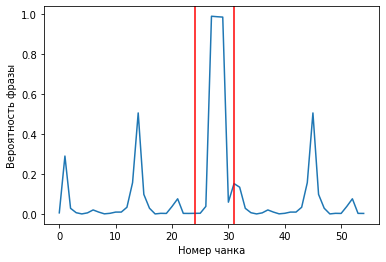

In [44]:
#!c1.8
import matplotlib.pyplot as plt

plt.plot(preds)
plt.axvline(x=len(speech), c='red')
plt.axvline(x=len(speech) + len(speech_true), c='red')
plt.ylabel('Вероятность фразы')
plt.xlabel('Номер чанка')

# Графички с моделями

Здесь я взял свои наиболее успешные модели по ходу развития данного нотбука

In [48]:
#!c1.8
sizes = []
macs = []
au_fa_fr = []

config = TaskConfig(hidden_size=32)
model = CRNN(config)
ckpt = torch.load('pretrained/baseline.pt')
model.load_state_dict(ckpt)

score = validation(model, val_loader, melspec_val, 'cpu')
size = get_size_in_megabytes(model)
mac = profile(model, (batch, ))[0]

sizes.append(size)
macs.apend(mac)
au_fa_fr.append(score)

102it [00:08, 11.55it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [53]:
#!c1.8
config = TaskConfig(cnn_out_channels=3, hidden_size = 14)
model = CRNN(config)
profile(model, (batch, ))
ckpt = torch.load('pretrained/14_hidden.pt')
model.load_state_dict(ckpt)

score = validation(model, val_loader, melspec_val, 'cpu')
print(score)
size = get_size_in_megabytes(model)
mac = profile(model, (batch, ))[0]

sizes.append(size)
macs.append(mac)
au_fa_fr.append(score)

In [56]:
#!c1.8
config = TaskConfig(cnn_out_channels=3, hidden_size = 12, kernel_size=(4, 20), stride=(2, 14))
model = CRNN(config)
profile(model, (batch, ))
ckpt = torch.load('pretrained/super.pt')
model.load_state_dict(ckpt)

score = validation(model, val_loader, melspec_val, 'cpu')
print(score)
size = get_size_in_megabytes(model)
mac = profile(model, (batch, ))[0]

sizes.append(size)
macs.append(mac)
au_fa_fr.append(score)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:08, 11.76it/s]


4.3998728315610466e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [79]:
#!c1.8
config = TaskConfig(cnn_out_channels=3, hidden_size = 10, kernel_size=(4, 18), stride=(2, 14))
model = CRNN(config)
profile(model, (batch, ))
ckpt = torch.load('pretrained/megasuper.pt')
model.load_state_dict(ckpt)
model = torch.quantization.quantize_dynamic(model)

score = validation(model, val_loader, melspec_val, 'cpu')
print(score)
size = get_size_in_megabytes(model)
mac = profile(model, (batch, ))[0]

sizes.append(size)
macs.append(mac)
au_fa_fr.append(score)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:05, 18.22it/s]


5.394663013334037e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [58]:
#!c1.8
config = TaskConfig(cnn_out_channels=3, hidden_size = 10, kernel_size=(4, 18), stride=(2, 14))
model = CRNN(config)
profile(model, (batch, ))
ckpt = torch.load('pretrained/quantized.pt')
model.load_state_dict(ckpt)

score = validation(model, val_loader, melspec_val, 'cpu')
print(score)
size = get_size_in_megabytes(model)
mac = profile(model, (batch, ))[0]

#sizes.append(size)
#macs.append(mac)
#au_fa_fr.append(score)

102it [00:03, 27.27it/s]


5.394663013334037e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


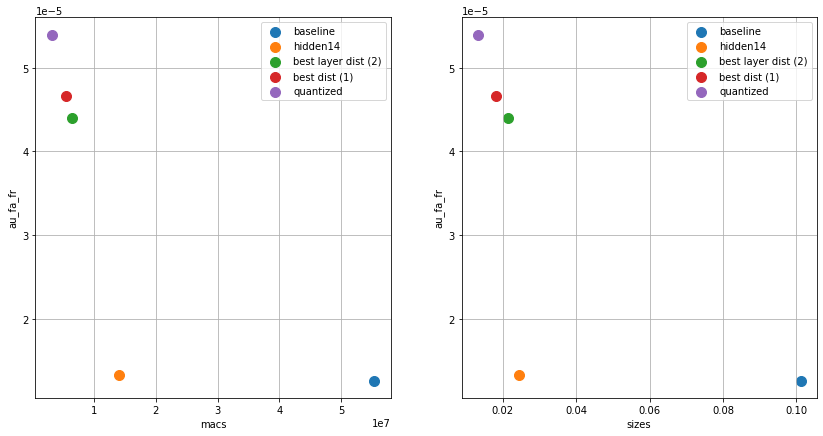

In [83]:
#!c1.8
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

names = ['baseline', 'hidden14', 'best layer dist (2)', 'best dist (1)', 'quantized']
for i in range(len(sizes)):
    axs[0].scatter([macs[i]], [au_fa_fr[i]], label=names[i], s=100)
    axs[1].scatter([sizes[i]], [au_fa_fr[i]], label=names[i], s=100)
    
axs[1].set_xlabel('sizes')
axs[1].set_ylabel('au_fa_fr')
axs[0].set_xlabel('macs')
axs[0].set_ylabel('au_fa_fr')
axs[1].legend()
axs[1].grid()
axs[0].grid()
axs[0].legend()

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [88]:
!git add dlahw2.ipynb pretrained

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/
	dlahw2.ipynb
	pretrained/
	speech.pt
	speech_true.pt

nothing added to commit but untracked files present (use "git add" to track)
